In [17]:
import numpy as np 
import scipy as sc
import sklearn as sk
import matplotlib.pyplot as plt

In [112]:
# creating sample data (1D example)

gen_fn = lambda x: np.sin((2*6) * np.pi * x / 800)

def gen_sample_data(n, tt_split): 

    idx = []
    while len(idx) < tt_split:
        r = np.random.randint(n)
        if r not in idx: idx.append(r)

    X_train_idx = np.array(idx)
    X_train = X_test[X_train_idx]
    Y_train = gen_fn(X_train_idx)
    X_test = np.linspace(-3, 3, n)

    return X_train_idx, X_train, Y_train, X_test


In [97]:
def kernel(X, Y, type): 

    # we do need to reconsider the computation of distance. 
    # good paper on taking the kernels wrt spherical distance by jeong et. al (2017)


    if type == 'rbf': 
        kerns = lambda zi, zj: np.exp(-0.5 * np.linalg.norm([zi - zj], 2)**2)

    if type == 'matern': 
        v = 1
        l = 1
        kerns = lambda zi, zj: (2 ** (1 - v) / sc.special.gamma(v)) * ((np.sqrt(2 * v)
                                            * np.abs(np.linalg.norm([zi - zj], 2))/ l) ** v
                                            ) * (sc.special.kv(v, np.sqrt(2 * v) * np.abs(np.linalg.norm([zi - zj], 2)) / l)
                                            ) if zi != zj else (2 ** (1 - v) / sc.special.gamma(v)) * ((np.sqrt(2 * v) * 
                                            1e-8/ l) ** v) * (sc.special.kv(v, np.sqrt(2 * v) * 1e-8 / l)) 

    K = np.empty((len(X), len(Y)))
    for i, zi in enumerate(X):
        for j, zj in enumerate(Y):
            K[i, j] = kerns(zi, zj)

    return K

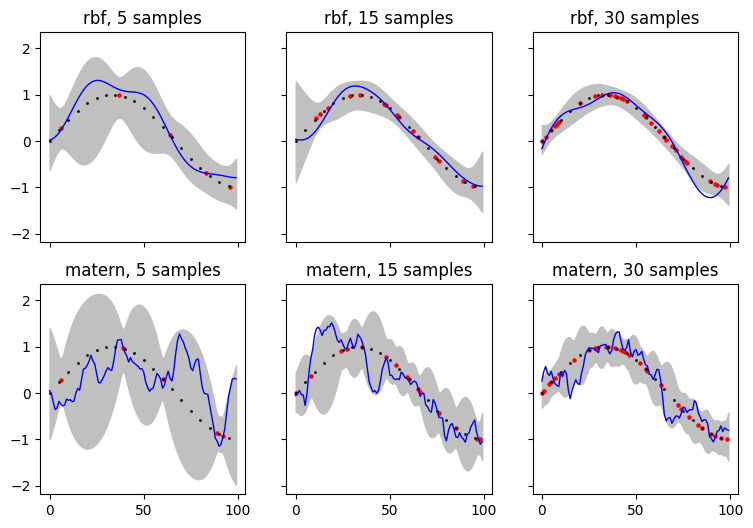

In [115]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6), sharey=True, sharex=True)

n = 100

i = 0 

for t in ['rbf', 'matern']: 

    j = 0

    for tt_split in [5, 15, 30]:
        X_train_idx, X_train, Y_train, X_test = gen_sample_data(n, tt_split)

        K21 = kernel(X_test,  X_train, t)
        K22 = kernel(X_train, X_train, t)
        K11 = kernel(X_test,  X_test, t)
        K12 = kernel(X_train, X_test, t)

        # following the definition for noisy observations in p. 16 (Rasmussen and Williams, 2006) : 
        # to fit a gaussian process regression 

        noise = np.eye(np.shape(K22)[0]) * 0.05
        mean = K21 @ np.linalg.inv(K22 + noise) @ Y_train
        cov  = K11 - (K21 @ np.linalg.inv(K22 + noise) @ K12)

        f_test = np.random.multivariate_normal(mean, cov)

        axes[i, j].plot(np.arange(n), f_test, ms=2, color='b', lw = 1) # interpolated points

        std = np.sqrt(np.diag(cov))
        axes[i, j].fill_between(np.arange(n), mean-2*std, mean+2*std, color='silver') # standard deviation 

        axes[i, j].scatter(X_train_idx, Y_train, marker='o', s=5, c='r') # sampled points 

        x = np.arange(0, n, 5)
        axes[i, j].scatter(x, gen_fn(x), s=1, c='k') # function from which sample points are from 

        axes[i, j].set_title(t + ", " + str(tt_split) + " samples") 

        j = j + 1

    i = i + 1

plt.show()